<a href="https://colab.research.google.com/github/smahesh2694/NEU_XAI/blob/master/LG_report1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**XAI Project Report** 

Visual defect inspection is of paramount importance during quality assurace and quality control in all manufacturing industries. This project aims to investigate an interpretable visual inspection framework for surface defect identification on hot-rolled steel strips. A classification model is built on the recommended open source steel visual defect dataset from the North-Eastern University, China called ‘NEU surface defect database’. As the accuracy obtained are satisfactory, two model-agnostic XAI approaches namely LIME and SHAP, are implemented on the trained model treating it to be a 'blackbox', and the results obtained over the period, are attached in this report for LG's perusal. This project is built on Keras with tensorflow as backend. For defect classification purpose, transfer learning is implemented using 'MobileNet' model pre-trained on ImageNet dataset (14 million images). 


 ***


#**Dataset**

NEU surface defect dataset ([NEU](http://faculty.neu.edu.cn/yunhyan/NEU_surface_defect_database.html)) has 6 classes of defects commonly found in steel strips, namely 

1.   Rolled-in scale (RS)
2.   Patches (Pa)
3.   Crazing (Cr)
4.   Pitted surface (PS)
5.   Inclusion (In)
6.   Scratches (Sc)

With 300 images on each class of defect, the dataset has a total of 1800 defective images. All images are grayscale and are of dimension 200x200. A screenshot of images from the dataset, across all classes of defects are attached below.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1ywt-hDfWYt9kMM4yYFXZQfMvpnjLXsiv' width=300 height=300/>
<figcaption>Classes in NEU dataset</figcaption></center>
</figure>

The dataset also has ground truth annotation of the bounding boxes which is to be utilised for evaluating the accuracy of the XAI approach chosen. The challenge with the images in the dataset can be inferred by observation. 

*   Interclass defect similarity
*   Intraclass defect variation

********












#**Model**

MobileNet model is used as the base model and its pre-trained weights are imported. As the model is loaded, the “include_top” argument is set to 'False', so the fully-connected output layers of the model used to make predictions is not included, allowing us to add and train a new output layer. Thus, transfer learning is implemented and all necessary packages are imported.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import keras
import cv2
import seaborn as sn
import matplotlib.pyplot as plt
from keras.layers.core import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.optimizers import SGD
from sklearn import preprocessing
from skimage.segmentation import mark_boundaries
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from xml.etree import ElementTree

Using TensorFlow backend.


In [3]:
base_model=MobileNet(weights='imagenet',include_top=False) 

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '







17227776/17225924 [==============================] - 1s 0us/step


A custom output layer which suits our NEU surface defect dataset is built on the top of the base_model (MobileNet). After the pooling 'GlobalAveragePooling2D' layer, a dense layer with 'ReLU' (Rectified Linear Unit) activation is added which is then fed into a softmax layer with 6 probability functions for 6 classes in the dataset.

In [0]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(6,activation='softmax')(x)

In [0]:
model=Model(inputs=base_model.input, outputs=preds)

In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

We start by freezing all of the base model’s layers, as we are trying to leverage the knowledge learned by the network from ImageNet dataset. By setting the base_model.trainable=False , the weights of the base_model are not updated during the training process.

In [0]:
base_model.trainable = False 

**Data Loading**

A split of 10 percent from each class is done randomly as test images. The model is not trained on these 180 images and so they are used to access the accuracy of the model's prediction. From the available 90 percent of data, a validation split of 20 percent is done as per standard procedure. The data is fed into the network for training through keras' flow_from_directory function with a batch size of 16. Also, the label_map of the model is retrieved from the generator.

In [0]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True, 
                                 validation_split=0.2)

In [9]:
bs = 16
train_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train',  
                                                 target_size=(200,200),     
                                                 batch_size=bs,
                                                 class_mode='categorical',                                                 
                                                 shuffle=True,
                                                 subset='training')

Found 1296 images belonging to 6 classes.


In [10]:
label_map = (train_generator.class_indices)
print(label_map)

{'Cr': 0, 'In': 1, 'PS': 2, 'Pa': 3, 'RS': 4, 'Sc': 5}


Similar to the training process, a generator for validation is built. Using 'categorical_crossentropy' as the loss function and SGD (Stochastic Gradient Descent) optimizer, the model is compiled. 

In [11]:
val_generator=train_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Train', 
                                                 target_size=(200,200),  
                                                 batch_size=bs,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation')

Found 324 images belonging to 6 classes.


In [12]:
model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['acc'])

In [0]:
#model.summary()

In [14]:
step_size_train = train_generator.n//train_generator.batch_size
print(step_size_train)
step_size_val = (val_generator.n//val_generator.batch_size)+1
print(step_size_val)

81
21


**Training**

With 25 initial epochs, the built model is fitted using fit_generator function with step sizes of 81 and 21, for training and validation respectively. The validation accuracy is observed to be high from the first epoch. The fitted model is evaluated with 99.6875 percent validation accuracy.

In [0]:
initial_epochs = 25

In [16]:
history = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=initial_epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/25
81/81 [==============================] - 477s 6s/step - loss: 0.2943 - acc: 0.9097 - val_loss: 0.0274 - val_acc: 0.9938
Epoch 2/25
81/81 [==============================] - 15s 181ms/step - loss: 0.0662 - acc: 0.9861 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 3/25
81/81 [==============================] - 15s 185ms/step - loss: 0.0392 - acc: 0.9900 - val_loss: 0.0116 - val_acc: 0.9938
Epoch 4/25
81/81 [==============================] - 15s 182ms/step - loss: 0.0374 - acc: 0.9892 - val_loss: 0.0151 - val_acc: 0.9969
Epoch 5/25
81/81 [==============================] - 15s 183ms/step - loss: 0.0279 - acc: 0.9915 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 6/25
81/81 [==============================] - 15s 185ms/step - loss: 0.0157 - acc: 0.9969 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 7/25
81/81 [==============================] - 15s 183ms/step - loss: 0.0241 - acc: 0.9915 - val_loss: 

In [17]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

21/21 [==============================] - 3s 133ms/step
Validating loss: 0.00040605845774903344
Validating accuracy: 1.0


**Fine tuning**

In order to build the model robust, the last 1/3 rd layers of the model are fine tuned on the NEU dataset by setting 'True' label to the 'model.trainable' paramater.

In [0]:
base_model.trainable = True

In [19]:
no_layers = len(base_model.layers)
print("Number of layers in the base model: ", no_layers)

Number of layers in the base model:  87


In [0]:
fine_tune_at = (2 * no_layers)/ 3

In [0]:
for layer in base_model.layers[:int(fine_tune_at)]:
  layer.trainable =  False

In [22]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


With 15 more epochs for fine tuning at the depth layers, our model is trained again to get about 99.9 percent validation accuracy.

In [23]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data=val_generator,
                   validation_steps=step_size_val,                
                   epochs=total_epochs,
                   initial_epoch = initial_epochs)

Epoch 26/40


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


81/81 [==============================] - 16s 199ms/step - loss: 0.0047 - acc: 0.9985 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 27/40
81/81 [==============================] - 15s 188ms/step - loss: 0.0062 - acc: 0.9985 - val_loss: 0.0035 - val_acc: 0.9969
Epoch 28/40
81/81 [==============================] - 15s 186ms/step - loss: 0.0054 - acc: 0.9977 - val_loss: 0.0062 - val_acc: 0.9969
Epoch 29/40
81/81 [==============================] - 15s 186ms/step - loss: 0.0085 - acc: 0.9985 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 30/40
81/81 [==============================] - 15s 186ms/step - loss: 0.0159 - acc: 0.9961 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 31/40
81/81 [==============================] - 15s 184ms/step - loss: 0.0054 - acc: 0.9992 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 32/40
81/81 [==============================] - 15s 185ms/step - loss: 0.0046 - acc: 0.9992 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 33/40
81/81 [==============================] - 15s 183ms/step - loss

In [24]:
scores = model.evaluate_generator(generator=val_generator,
                         steps=step_size_val,verbose = 1)
print('Validating loss:', scores[0])
print('Validating accuracy:', scores[1])

21/21 [==============================] - 3s 138ms/step
Validating loss: 0.0003134659537627832
Validating accuracy: 1.0




---



# **Accuracy Plots**

The training accuracy (and loss) is plotted along validation accuracy (and loss) against the number of epochs to get the accuracy plot. In order to differentiate the initial training process from fine tuning, the plot is split with a green line for better interpretation of results.

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

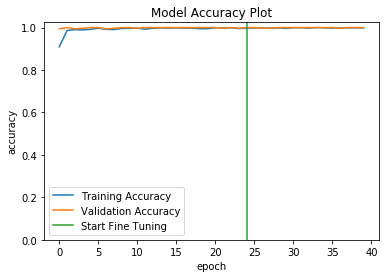

In [27]:
plt.figure(figsize=(6, 4))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, max(plt.ylim())+0.02])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Model Accuracy Plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

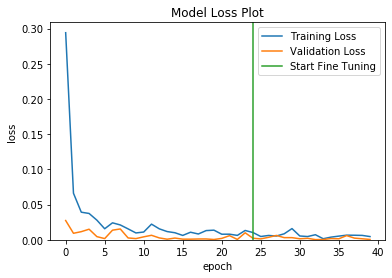

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, max(plt.ylim())])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Model Loss Plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()



---



# **Testing**

In order to test the model, it was made to predict the class on the test set (10 percent of original dataset which was untouched) using a test generator with a batch size of 1. By obtaining the prediction indices for each input test image, the classification report and the confusion matrix has been plotted to visualize the evaluation of the model.

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True)

In [30]:
test_generator = test_datagen.flow_from_directory('/content/drive/My Drive/NEU surface defect database - test split/Test',
                                                  target_size=(200,200),     
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle = False)

Found 180 images belonging to 6 classes.


In [31]:
step_size_test = test_generator.n//test_generator.batch_size
print(step_size_test)
test_generator.reset()

180


In [32]:
predIndxs = model.predict_generator(test_generator, steps = step_size_test, verbose=1 )
predIndxs = np.argmax(predIndxs, axis=1)

180/180 [==============================] - 57s 319ms/step


Predictions for each images are printed along its associated labels . The results can also be  exported and documented as a csv format file for further evaluation of model accuracy and precision.

In [33]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print("Labels : ", labels)

predictions = [labels[k] for k in predIndxs]
print(predictions)

Labels :  {0: 'Cr', 1: 'In', 2: 'PS', 3: 'Pa', 4: 'RS', 5: 'Sc'}
['Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'Cr', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'In', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'PS', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'Pa', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'RS', 'Sc', 'Sc', 'Sc', 'Sc', 'Sc', 'Sc'

In [0]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv('/content/drive/My Drive/XAI_results/results.csv',index=False)



---



# **Results Evaluation**


The classification report with metrics such as precision, recall and f-1 score is plotted for each individual classes. As the validation accuracy is about 99.7 percent, we obtain a 100 percent the test accuracy on all test images.


*   Precision (Pr) is the ratio of relevant instance over retrieved instance. It can be calculated using the formula TP / (TP + FP).
*   Recall (Rc) is the ratio of number of relevant instance that were actually retrieved. It's calculated with the formula TP / (TP + FN).
*   F1 score is the hormonic mean of precision and recall. It's calculated by 2 * (Pr * Rc ) / (Pr + Rc).











In [35]:
print(classification_report(test_generator.classes, predIndxs, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

          Cr       1.00      1.00      1.00        30
          In       1.00      1.00      1.00        30
          PS       1.00      1.00      1.00        30
          Pa       1.00      1.00      1.00        30
          RS       1.00      1.00      1.00        30
          Sc       1.00      1.00      1.00        30

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



The confusion matrix helps to visualize the predicted labels of our test images along the actaul ground truth labels. It can be noted that all test images have been correctly predicted by our model.

In [36]:
cm = confusion_matrix(test_generator.classes,predIndxs)
print(cm)

total = sum(sum(cm))
print("Total test images: ", total)
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2] + cm[3, 3] + cm[4, 4] + cm[5, 5]) / total
print("Accuracy: {:.3f}".format(acc))
print("Lables:")
print("x axis: Predicted")
print("y axis: Actual")

[[30  0  0  0  0  0]
 [ 0 30  0  0  0  0]
 [ 0  0 30  0  0  0]
 [ 0  0  0 30  0  0]
 [ 0  0  0  0 30  0]
 [ 0  0  0  0  0 30]]
Total test images:  180
Accuracy: 1.000
Lables:
x axis: Predicted
y axis: Actual


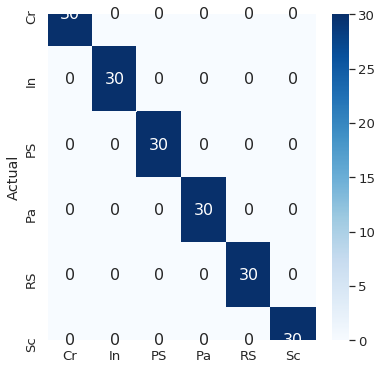

In [37]:
plt_cm = pd.DataFrame(cm, index=test_generator.class_indices.keys(), columns=test_generator.class_indices.keys())
plt_cm.index.name = "Actual"
plt_cm.index.columns = "Predicted"
plt.figure(figsize = (6,6))
sn.set(font_scale=1.2)
sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

The model can also be saved and loaded at any instance to reduce the training time and to increase the efficiency for the end user.

In [0]:
#model.save('/content/drive/My Drive/xai_model/model.h5')

In [0]:
#saved_model = load_model('/content/drive/My Drive/xai_model/model.h5')



---



# **Prediction**

Given the path of the input image, the test_img is loaded and preprocessed as per the requirement for prediction function. Now the model predicts the probability of the image belonging to each class and the output is obtained by getting the maximum value of prediction and matching it with its associated labels. The order of the prediction probability is also noted as it helps us to visualize the super-pixels responsible for the preiction of each classes by comparing them with the explanation provided by LIME.





> The ground truth annotation provided in the NEU dataset is exploited to visualize the bounding boxes for the defect region in the test images. They can be compared to the masks generated by LIME for each prediction to evaluate the accuracy and efficieny of the model built.



In [0]:
annotation = '/content/drive/My Drive/NEU-DET/ANNOTATIONS/scratches_299.xml'
image_path = "/content/drive/My Drive/NEU surface defect database - test split/Test/Sc/Sc_299.bmp"

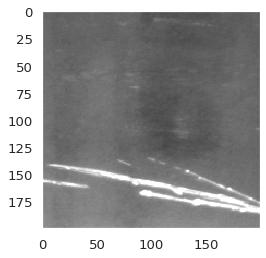

In [55]:
test_img = image.load_img(image_path)
plt.imshow(test_img)
plt.grid(None)

test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)
test_img /= 255

In [56]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'}

result = model.predict(test_img)
print(result)

prediction = result.argmax(axis=1)
print(prediction)

output = labels[int(prediction)]
print(output)

[[7.3436706e-07 1.0907484e-05 3.8896781e-07 2.9423903e-05 4.0878731e-06
  9.9995446e-01]]
[5]
Scratches


[[2, 135, 200, 186]]


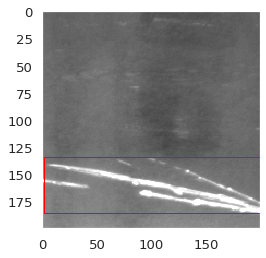

In [57]:
def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

b_img = cv2.imread(image_path)
boxes = extract_boxes(annotation)
print(boxes)

plt.grid(None)
for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 1)
  
  plt.imshow(b_img)

# LIME

Local Interpretable Model-agnostic Explanation (LIME) is a novel explanation technique that explains the prediction of any classifier by treating it as a 'blackbox' model, in an interpretable manner by learning an interpretable model locally around the prediction. LIME tests the variations in the predictions of the model with corresponding perturbations to the input data. So, LIME generates a new dataset for each input, consisting of permuted samples and its corresponding predictions. Then it trains an interpretable model which is weighted by the proximity of the sampled instances to the instance of interest. LIME now explains the predictions by intrepreting the local model. 



> LIME is pip installable and the necessary packages for the explanation of image classification are imported.



In [44]:
!pip install lime

     |████████████████████████████████| 276kB 4.8MB/s 
  Created wheel for lime: filename=lime-0.1.1.36-cp36-none-any.whl size=284191 sha256=192e374dc0aeb51e05231ca72d91af2a66cf5fb132419971d53f55790e8c62cf
  Stored in directory: /root/.cache/pip/wheels/a9/2f/25/4b2127822af5761dab9a27be52e175105772aebbcbc484fb95
Successfully built lime


In [0]:
%load_ext autoreload
%autoreload 2
import os, sys
import lime
from lime import lime_image

In [0]:
explainer = lime_image.LimeImageExplainer()

The 'explain_instance' function gets the input test image and the model's prediction values and generates the masks in terms of super-pixels which are responsible for the classification of the test image to a particular class. By changing the 'top_labels' attribute, the number of masks to be generated for each test image is determined. It's assigned value 6 denotes the number of classes in our dataset.



> The explanation function takes about 6 secs for each image with GPU processing and it has been recorded to be about 10 minutes under normal CPU.


In [58]:
%%time

explanation = explainer.explain_instance(test_img[0], model.predict, top_labels=6, hide_color=0)

CPU times: user 3.1 s, sys: 294 ms, total: 3.4 s
Wall time: 3.29 s


In [48]:
labels = {0: 'Crazing', 1: 'Inclusion', 2: 'Pitted Surface', 3: 'Patches', 4: 'Rolled-in Scale', 5: 'Scratches'};
print("Predictions: \n")
for i in range(len(explanation.top_labels)):
  rank = explanation.top_labels[i]
  print(i,labels[rank])  

Predictions: 

0 Scratches
1 Patches
2 Inclusion
3 Rolled-in Scale
4 Crazing
5 Pitted Surface


Given the order of the probability of prediction, the value of 'p' is set to visualize the patches responsible for its classification. 'p' set to 0 explains the top prediction by the model.

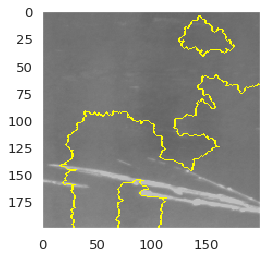

In [49]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.grid(None)

To increase the interpretabilty of LIME, 'hide_rest' attribute is set to 'True' as it sets the values of pixels other than the chosen super-pixels to gray. 

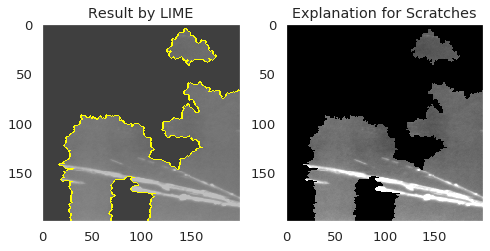

In [50]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=True, 
                                            num_features=10, hide_rest=True)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.title('Result by LIME')
plt.grid(None)

plt.subplot(2,2,2)
plt.imshow(temp)
plt.title(title)
plt.grid(None)

By changing the value of 'positive_only' attribute to False, we can get the pixels responsible for a particular classification to 'green' shade and the pixels which affects the classification to 'red' shade. It can be noted that the value of 'num_features' can be modified which is set as a complexity measure for minimising the loss function.

The input test image along its ground truth bounding boxes and the explanations by LIME are plotted together to interpret 

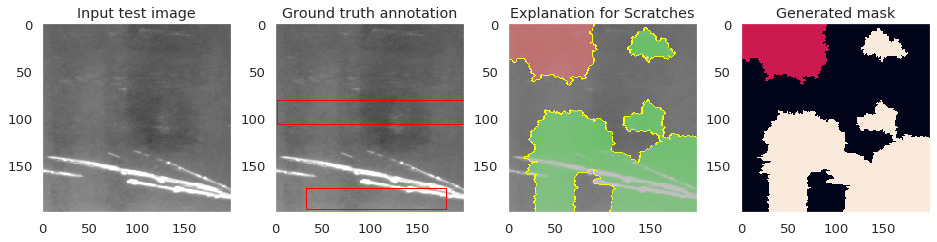

In [51]:
p = 0
temp, mask = explanation.get_image_and_mask(explanation.top_labels[p], positive_only=False, 
                                            num_features=10, hide_rest=False)
top = labels[explanation.top_labels[p]]
title = "Explanation for " + top

plt.figure(figsize=(16, 16))
plt.subplot(4,4,1)
plt.imshow(test_img[0])
plt.title('Input test image')
plt.grid(None)

plt.subplot(4,4,2)
plt.imshow(b_img)
plt.title('Ground truth annotation')
plt.grid(None)

plt.subplot(4,4,3)
plt.imshow(mark_boundaries(temp / 2 + 0.25, mask))
plt.title(title)
plt.grid(None)

plt.subplot(4,4,4)
plt.imshow(mask)
plt.title('Generated mask')
plt.grid(None)

# SHAP

In [0]:
shap_Cr = '/content/drive/My Drive/NEU orig/Cr/*.bmp'
shap_In = '/content/drive/My Drive/NEU orig/In/*.bmp'
shap_PS = '/content/drive/My Drive/NEU orig/PS/*.bmp'
shap_Pa = '/content/drive/My Drive/NEU orig/Pa/*.bmp'
shap_RS = '/content/drive/My Drive/NEU orig/RS/*.bmp'
shap_Sc = '/content/drive/My Drive/NEU orig/Sc/*.bmp'

shap_data = [shap_Cr, shap_In, shap_PS, shap_Pa, shap_RS, shap_Sc]

NameError: ignored

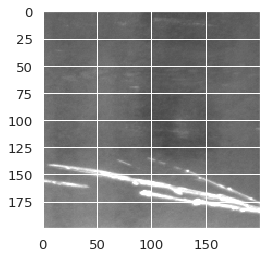

In [53]:
img = image.load_img(image_path, target_size=(200,200))
plt.imshow(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = saved_model.predict(img)
print(result)

prediction = result.argmax(axis=-1)
print(prediction)

output = labels[int(prediction)]
print(output)

In [0]:
b_img = cv2.imread(image_path)

def extract_boxes(filename):
	tree = ElementTree.parse(filename)
	root = tree.getroot()	
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	return boxes 

boxes = extract_boxes(annotation)
print(boxes)

for i in range(len(boxes)):
  pt1 = boxes[i][0], boxes[i][1]
  pt2 = boxes[i][2], boxes[i][3]
  #print(pt1, pt2)
  cv2.rectangle(b_img, pt1, pt2, (255, 0, 0), 2)
  plt.imshow(b_img)

In [0]:
!pip install shap

In [0]:
%%time
import glob
cv_img = []

for i in range(len(shap_data)):
  for ig in glob.glob(shap_data[i]):
    n = cv2.imread(ig)
    cv_img.append(n)

oo = np.array(cv_img)

In [0]:
oo.shape

In [0]:
shap_test = image.load_img(image_path) #, grayscale=True)
plt.imshow(shap_test)

shap_test = image.img_to_array(shap_test)
shap_test = np.expand_dims(shap_test, axis=0)
#shap_test = preprocess_input(shap_test)

In [0]:
shap_test.shape

In [0]:
for i in range(len(saved_model.layers)):
  print(i , saved_model.layers[i])

In [0]:
%%time
import keras.backend as K
import shap
m = 16

def map2layer(x, layer):
  feed_dict = dict(zip([saved_model.layers[0].input], [preprocess_input(x.copy())]))  
  return K.get_session().run(saved_model.layers[layer].input, feed_dict)

e = shap.GradientExplainer((saved_model.layers[m].input, saved_model.layers[-1].output),
                           map2layer(preprocess_input(oo.copy()),m), local_smoothing = 0)

shap_values, indexes = e.shap_values(map2layer(shap_test, m), ranked_outputs=6)

index_names = np.vectorize(lambda l: labels[l])(indexes)

shap.image_plot(shap_values, shap_test, index_names)